------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

Python 3.7.15


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [ ]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2022-11-16 22:52:16--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.3’

sent_lexicon.3      100%[===================>] 647.05K  --.-KB/s    in 0.005s  

2022-11-16 22:52:16 (125 MB/s) - ‘sent_lexicon.3’ saved [662577/662577]

--2022-11-16 22:52:17--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubuserconte

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [ ]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
# First reformat the lexicon into an easy to use dictionary containing all the information

# In this dictionary the keys are the words and the values are the information such as type and pos1

# Import a library that helps us split a string conveniently
import re

In [ ]:
# Initialize an empty dictionary
lexicon_dict = {}

# Open the lexicon file for reading
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  
  # For every line (which corresponds to a word in this case)
  for line in f:

    # Split the string on spaces and '=':
    lex_elements = re.split(' |=', line)

    # Cut the '\n' from the end
    lex_elements[-1] = lex_elements[-1][:-1]

    # Add the relevant information to the dictionary using the word as the key
    lexicon_dict[lex_elements[5]] = lex_elements[1], lex_elements[3], lex_elements[7], lex_elements[9], lex_elements[11]

# Show user what this dict looks like
print("The lexicon dictionary looks as follows: ", lexicon_dict)

The lexicon dictionary looks as follows:  {'abandoned': ('weaksubj', '1', 'adj', 'n', 'negative'), 'abandonment': ('weaksubj', '1', 'noun', 'n', 'negative'), 'abandon': ('weaksubj', '1', 'verb', 'y', 'negative'), 'abase': ('strongsubj', '1', 'verb', 'y', 'negative'), 'abasement': ('strongsubj', '1', 'anypos', 'y', 'negative'), 'abash': ('strongsubj', '1', 'verb', 'y', 'negative'), 'abate': ('weaksubj', '1', 'verb', 'y', 'negative'), 'abdicate': ('weaksubj', '1', 'verb', 'y', 'negative'), 'aberration': ('strongsubj', '1', 'noun', 'n', 'negative'), 'abhor': ('strongsubj', '1', 'verb', 'y', 'negative'), 'abhorred': ('strongsubj', '1', 'adj', 'n', 'negative'), 'abhorrence': ('strongsubj', '1', 'noun', 'n', 'negative'), 'abhorrent': ('strongsubj', '1', 'adj', 'n', 'negative'), 'abhorrently': ('strongsubj', '1', 'anypos', 'n', 'negative'), 'abhors': ('strongsubj', '1', 'noun', 'n', 'negative'), 'abidance': ('strongsubj', '1', 'noun', 'n', 'positive'), 'abide': ('strongsubj', '1', 'anypos', '

In [ ]:
def binary_score(review):
  """
  Calculate the binary score of a single review.

  Parameters
  ----------
  review: dict
    Dictionary that contains information about a single review. in this function
    the 'content' key of the dict is used, which stores all the text. 

  Returns
  -------
  score_count: int
    The binary score of a single review as an integer. The total score is 
    calculated by adding 1 when a word is 'positive' and subtracting 1 when a
    word is negative.
  """
  # Initialize the binary score
  score_count = 0
 
  # Look at each individual word in a review
  for sentence in review['content']:
    for word in sentence:

      # Check if the word is in the lexicon
      if word[0].lower() in lexicon_dict.keys():

        # Check in the lexicon if the word is negative or positive (or neutral)
        if lexicon_dict[word[0].lower()][-1] == 'negative':
          score_count -= 1
        elif lexicon_dict[word[0].lower()][-1] == 'positive':
          score_count += 1
  
  return score_count


# Function that classifies a review as positive or negative using treshold
def classification(score_count, treshold=8):
  if score_count > treshold:
    return 'POS'
  else:
    return 'NEG'


# Function that returns the 'true' labels of inputted reviews
def true_sentiments(reviews):
    
  # For every review add its true sentiment to the sentiments list
  sentiments = [review['sentiment'] for review in reviews]

  return sentiments


def token_list(true_labels, predicted_labels):
  """
  Retrieve the token list.

  Parameters
  ----------
  true_labels: list
    List of strings where each element is either 'POS' or 'NEG', these are the
    'true' review sentiments.
  predicted_labels: list
    List of strings where each element is either 'POS' or 'NEG', these are the
    'predicted' review sentiments.

  Returns
  -------
  token_results: list
    A list containing binary indicators, where 1 indicates a correct 
    classification and 0 an incorrect classification.
  """
  # Initialize an empty list
  token_results = []

  # Compare all your predicted labels to the true labels
  for i in range(len(true_labels)):
    if true_labels[i] == predicted_labels[i]:
      token_results += [1]
    else:
      token_results += [0]

  return token_results


# Function that calculates the prediction accuracy using the token list
def token_acc(token_results):
  # Get the total sum of correct predictions
  sum_correct = sum(token_results)

  # Devide it by the total amount of tokens
  token_accuracy = sum_correct / len(token_results)

  return token_accuracy


In [ ]:
# Perform the lexicon based prediction

# Initialize a list to store your predictions
predicted_labels = []

# For every review, make a positive or negative prediction
for review in reviews:
  # Calculate a reviews binary score
  score_count = binary_score(review)

  # Label the review 'POS' or 'NEG'
  label = classification(score_count)

  # Add the prediction to the prediction list
  predicted_labels += [label]

# Retrieve the true sentiments 
true_labels = true_sentiments(reviews)

In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = token_list(true_labels, predicted_labels)
token_accuracy = token_acc(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
def weighted_binary_score(review):
  """
  Calculate the weighted binary score of a single review.

  Parameters
  ----------
  review: dict
    Dictionary that contains information about a single review. in this function
    the 'content' key of the dict is used, which stores all the text. 

  Returns
  -------
  score_count: int
    The weighted binary score of a single review as an integer. The total score 
    is calculated by adding 1 when a word is 'weak positive', 2 when a word is
    'strong postive' and -1 and -2 when a word is 'weak negative' or 'strong
    negative' respectively.
  """
  # Initialize the binary score at 0
  score_count = 0

  # Look at every word in the review
  for sentence in review['content']:
    for word in sentence:

      # Check if the word is in the lexicon
      if word[0].lower() in lexicon_dict.keys():

        # If the word is negative
        if lexicon_dict[word[0].lower()][-1] == 'negative':

          # Check the magnitude of the sentiment
          if lexicon_dict[word[0].lower()][0] == 'weaksubj':
            score_count -= 1
          else:
            score_count -= 2

        # If the word is positive
        elif lexicon_dict[word[0].lower()][-1] == 'positive':

          # Check magnitude of sentiment
          if lexicon_dict[word[0].lower()][0] == 'weaksubj':
            score_count += 1
          else:
            score_count += 2
  
  return score_count


# Function that calculates new treshold
def new_treshold(reviews):
  """
  Calculate a new appropriate treshold

  Parameters
  ----------
  reviews: list
    List containing all the 2000 reviews. Each element in the list is a dict
    containing the information of a single review.

  Returns
  -------
  treshold: int
    A new appropriate treshold is returned. Calculated by finding the average
    of the weighted binary scores of ALL reviews.
  """
  score_counters = []

  # For every review, calculate its weighted binary score
  for review in reviews:
    score_counters += [weighted_binary_score(review)]

  # New treshold is the average of all weighted binary scores
  treshold = math.ceil(sum(score_counters) / len(score_counters))

  return treshold

In [ ]:
# Perform the magnitude based lexicon classification

# Initialize a list to store your predictions
predicted_labels = []

# Calculate the new_treshold
treshold = new_treshold(reviews)

for review in reviews:
  # Calculate a reviews binary score
  score_count = weighted_binary_score(review)

  # Label the review 'POS' or 'NEG' (with new treshold)
  label = classification(score_count, treshold=treshold)

  # Add the prediction to the prediction list
  predicted_labels += [label]

In [ ]:
# Calculate the accuracy
magnitude_results = token_list(true_labels, predicted_labels)
magnitude_accuracy = token_acc(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.3) Make a barplot of the two results (0.5pt)

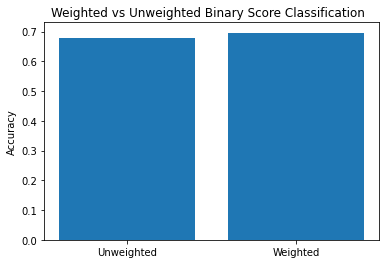

In [ ]:
methods = ['Unweighted', 'Weighted']
accuracies = [token_accuracy, magnitude_accuracy]

plt.bar(methods, accuracies)
plt.title('Weighted vs Unweighted Binary Score Classification  ')
plt.ylabel('Accuracy')
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

**Review specific treshold**

It would be better to use a treshold that does take into account the document length. In the explained scenario previously used, the treshold is based on the average review length, meaning a review of average length has a treshold of 8, because on average it will have 8 more positive than negative words. Reviews that are longer than average length, for example twice as long, will on average then have 2 * 8 more positive than negative words. 

In short, reviews longer than average length will tend to be above the treshold faster, and reviews shorter than average length will tend to be below the treshold more often. 

A different way to implement a treshold is to then include the review length in the calculation of the treshold, and making it a treshold specific for every reveiw. We can use the treshold that we used before, and then multiply it by however much the current review is longer or shorter than the average review. Meaning if a review is twice as long as the average review, the treshold will be twice as high. This is implemented below:

In [ ]:
def calc_review_length(review):
  """
  Calculate the length of a review.

  Parameters
  ----------
  review: dict
    Dictionary that contains information about a single review. in this function
    the 'content' key of the dict is used, which stores all the text. 

  Returns
  -------
  review_length: int
    The length in words (excluding interpunction signs such as points and 
    commas) of a specific review
  """
  review_length = 0

  for sentence in review['content']:
    # Only keep the words (not the commas etc)
    all_words = [sentence[i] for i in range(len(sentence)) if 
                  sentence[i][0].lower().isalpha()]

    # Add the amount of words in sentence to the total of the review
    review_length += len(all_words)
    # review_length += len(sentence)

  return review_length

# Function to calculate the new treshold depending on the document length
def treshold_factor(review_length, average_length, old_treshold=8):

  # Review length (divided by average length) multiplied with avg treshold
  doc_treshold = old_treshold * (review_length / average_length)

  return math.ceil(doc_treshold)


# Calculate all the review lengths
all_review_lengths = [calc_review_length(review) for review in reviews]

# Calculate the average review length
average_length = sum(all_review_lengths) / len(all_review_lengths)

In [ ]:
# Calculate the accuracy of using this new document specific treshold,
# without using magnitude information

# Initialize a list to store your predictions
predicted_labels = []

# For every review, make a positive or negative prediction
for review in reviews:
  # Calculate a reviews binary score
  score_count = binary_score(review)

  # Calculate review specific treshold based on the document length
  review_length = calc_review_length(review)
  treshold = treshold_factor(review_length, average_length)
  
  # Label the review 'POS' or 'NEG'
  label = classification(score_count, treshold=treshold)

  # Add the prediction to the prediction list
  predicted_labels += [label]

# True sentiments 
true_labels = true_sentiments(reviews)

# Calculate the accuracy (document specific treshold, no magnitude info)
new_nomag_results = token_list(true_labels, predicted_labels)
new_nomag_accuracy = token_acc(new_nomag_results)

print("Accuracy: %0.2f" % new_nomag_accuracy)

Accuracy: 0.67


In [ ]:
# Calculate the accuracy of using this new document specific treshold,
# without using magnitude information

# Initialize a list to store your predictions
predicted_labels = []

# Calculate the basis treshold
basis_treshold = new_treshold(reviews)

for review in reviews:
  # Calculate a reviews weighted binary score (using magnitude info)
  score_count = weighted_binary_score(review)

  # Calculate review specific treshold based on the document length
  review_length = calc_review_length(review)
  treshold = treshold_factor(review_length, average_length, basis_treshold)

  # Label the review 'POS' or 'NEG' (with new treshold)
  label = classification(score_count, treshold=treshold)

  # Add the prediction to the prediction list
  predicted_labels += [label]

# Calculate the accuracy
new_mag_results = token_list(true_labels, predicted_labels)
new_mag_accuracy = token_acc(new_mag_results)
print("Accuracy: %0.2f" % new_mag_accuracy)

Accuracy: 0.70


In [ ]:
# Display all accuracies one last time:

# Not using magnitude information
print("Accuracies of classifiers\033[1m not\033[0m using magnitude information:")
print("--------------------------------------")
print("Non-document specific treshold: %0.3f" % token_accuracy)
print("Document specific treshold    : %0.3f" % new_nomag_accuracy)
print("Accuracy improvement          : %0.3f" % (new_nomag_accuracy - token_accuracy))
print("")

# Using magnitude information
print("Accuracies of classifiers\033[1m using\033[0m magnitude information:")
print("--------------------------------------")
print("Non-document specific treshold: %0.3f" % magnitude_accuracy)
print("Document specific treshold    : %0.3f" % new_mag_accuracy)
print("Accuracy improvement          : %0.3f" % (new_mag_accuracy - magnitude_accuracy))

Accuracies of classifiers not using magnitude information:
--------------------------------------
Non-document specific treshold: 0.677
Document specific treshold    : 0.674
Accuracy improvement          : -0.003

Accuracies of classifiers using magnitude information:
--------------------------------------
Non-document specific treshold: 0.696
Document specific treshold    : 0.697
Accuracy improvement          : 0.001


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

**Answer Q2.1**

The prediction of such samples in the test dataset might be wrong (biased), and the prediction is more likely to be the sentiment class where we have the unseen words. For example, if a test sample has unseen words in the 'positive' but not in the 'negative' sentiment class in the training dataset and we don't skip these words in the 'positive' sentiment class when predicting, the predicted class of this sample will be more likely be 'positive' sentiment, even if this review is clearly negative. We explain with the help of the following quation (which defines how our model works).

$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

In the summation, we notice that the log of the conditional probabilities of the words are summed. If we skip the zero probabilities (for unseen words), these probabilities are within (0, 1). We then know that the log of each probability is negative, so as the sum of them all. However, if we only skip the unseen words in one class in case 2, the log of the conditional probabilities of these unseen words will still be added for the class where these words are seen. This means more negative values are added for the class where the words are seen, which will make the target of this class in the argmax function more likely to be smaller than that of class where we skipped the unseen words. Then the prediction will more likely be the class where we skipped the unseen words.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
# Function to devide the reviews into training and testing data
def train_test_split(reviews, pos_split = 899, neg_split = 899):
  train_reviews = []
  test_reviews = []

  for review in reviews:
    if review['sentiment'] == 'POS' and review['cv'] <= pos_split:
      train_reviews += [review]
    elif review['sentiment'] == 'POS' and review['cv'] > pos_split:
      test_reviews += [review]

    elif review['sentiment'] == 'NEG' and review['cv'] <= neg_split:
      train_reviews += [review]
    else:
      test_reviews += [review]

  return train_reviews, test_reviews


def generate_Ngrams(reviews, gram_order=1):
  text = [token[0].lower() for review in reviews for sentence in review['content'] for token in sentence]
  # because bigrams and trigrams should be generated w.r.t each sentence, we create this nested list
  text_in_sentences = []
  for review in reviews:
    for sentence in review['content']:
      s = []
      for token in sentence:
        s.append(token[0].lower())
      text_in_sentences.append(s)
  # generate bigrams/trigrams if asked to
  if gram_order == 2:
    bigram =  [' '.join(gram) for text in text_in_sentences for gram in ngrams(text, 2)]
    text += bigram
  elif gram_order == 3:
    bigram =  [' '.join(gram) for text in text_in_sentences for gram in ngrams(text, 2)]
    trigram = [' '.join(gram) for text in text_in_sentences for gram in ngrams(text, 3)]
    text = text + bigram + trigram
  elif gram_order != 1:
    raise TypeError("gram_order must be 1, 2 or 3")
  
  return text

def create_vocabulary(reviews, gram_order=1):
  """
  Create a vocabulary of all reviews and keep track of the counts of the
  elements in that vocabulary.

  Parameters
  ----------
  reviews: list
    List containing all the 2000 reviews. Each element in the list is a dict
    containing the information of a single review.

  Returns
  -------
  vocabulary: dict
    Returns a dictionary, where the keys are all the tokens present in the
    reviews. The values are the count of how many times that token was seen
    in a positive or negative review. 
    
    For example:
    Unigram: vocabulary['amazing'] = {'POS': 95, 'NEG': 55}
    Bigram: vocabulary['very good'] = {'POS': 88, 'NEG': 47}
    Trigram: vocabulary['not very good'] = {'POS': 2, 'NEG': 6}
  """
  pos_reviews = [review for review in reviews if review['sentiment'] == 'POS']
  neg_reviews = [review for review in reviews if review['sentiment'] == 'NEG']

  pos_text =  generate_Ngrams(pos_reviews, gram_order)
  neg_text = generate_Ngrams(neg_reviews, gram_order)

  vocabulary = {}
  # If the word is not yet in the vocabulary, initialize it
  # count the frequencies of the grams in text
  for gram in pos_text:
    if gram not in vocabulary:
      vocabulary[gram] = {'POS': 1, 'NEG': 0}
    # Otherwise if already present, add 1 to the positive count
    else:
      vocabulary[gram]['POS'] += 1
  for gram in neg_text:
    if gram not in vocabulary:
      vocabulary[gram] = {'POS': 0, 'NEG': 1}
    # Otherwise if already present, add 1 to the positive count
    else:
      vocabulary[gram]['NEG']+= 1

  return vocabulary


def token_amounts(vocabulary, k=0):
  # Calculate amount of tokens in 'POS' class and 'NEG' class
  tokens_pos, tokens_neg = 0, 0

  for word in vocabulary:
    tokens_pos += vocabulary[word]['POS'] + k
    tokens_neg += vocabulary[word]['NEG'] + k

  # Store them in useful dictionary
  token_counts = {'POS': tokens_pos, 'NEG': tokens_neg}

  return token_counts


# Function that retrieves the prior probabilities
def retrieve_prior(train_reviews):
  # Get a list of all the true labels
  true_labels = true_sentiments(train_reviews)
  N_reviews = len(train_reviews)

  # Our classes can be positive or negative:
  classes = ['POS', 'NEG']

  # Also store the prior in an easy to use dictionary
  prior = {'POS': 0, 'NEG': 0}

  for current_class in classes:
    # The prior is the amount of reviews of a class divided by the total amount
    prior[current_class] = true_labels.count(current_class) / N_reviews

  return prior


# Function which retrieves the conditional probabilities
def get_conditional_prob(vocabulary, k=0):
  # Our classes can be positive or negative:
  classes = ['POS', 'NEG']

  cond_prob = {}

  counts = token_amounts(vocabulary, k=k)

  for word in vocabulary:
    cond_prob[word] = {'POS': 0, 'NEG': 0}

  for current_class in classes:
    for word in vocabulary:
      cond_prob[word][current_class] = (vocabulary[word][current_class] + k) / counts[current_class]

  return cond_prob


# Function that applies the multinomial as given by the pseudocode
def apply_multinomialNB(review, vocabulary, prior, cond_prob, gram_order=1):
  score = {'POS': 0, 'NEG': 0}

  # Our classes are positive or negative
  classes = ['POS', 'NEG']

  for current_class in classes:
    score[current_class] = np.log(prior[current_class])
    text = generate_Ngrams([review], gram_order)
    # Count the score
    for word in text:
      if word in cond_prob:
        if cond_prob[word]['POS'] != 0 and cond_prob[word]['NEG'] != 0:
          score[current_class] += np.log(cond_prob[word][current_class])

  if score['POS'] > score['NEG']:
    return 'POS'
  else:
    return 'NEG'


# Global function that performs all the steps necessary to do the NaiveBayes
def perform_NaiveBayes(train_reviews, test_reviews, k=0, gram_order=1):
  # Create a vocabulary
  vocabulary = create_vocabulary(train_reviews, gram_order)

  # Calculate the prior
  prior = retrieve_prior(train_reviews)

  # Get the conditional probability
  cond_prob = get_conditional_prob(vocabulary, k)

  # Make your predictions using these variables
  predictions = [apply_multinomialNB(review, vocabulary, prior, cond_prob, gram_order) 
                    for review in test_reviews]

  # Get the true_labels
  true_labels = true_sentiments(test_reviews)

  # Get your results
  results = token_list(true_labels, predictions)
  accuracy = token_acc(results)

  return predictions, accuracy

In [ ]:
# Split the data
train_reviews, test_reviews = train_test_split(reviews)

# Perform the NaiveBayes
NB_unigram_accuracy = perform_NaiveBayes(train_reviews, test_reviews, gram_order=1)[1]

print("Naive Bayes Unigram Accuracy = %0.3f" % NB_unigram_accuracy)

Naive Bayes Unigram Accuracy = 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

**Answer Q2.3**

No, accuracy will not be a good way to evaluate largely imbalanced data since accuracy is only trustworthy on mostly balanced data. When 90% of the instances are of positive movie reviews, the accuracy will mostly reflect the model's performance on the positive reviews while the performance on the negative reveiws is negelected. This is because the accuracy only evaluates how many instances are predicted correctly but does not take into account which class the instance is from. As a result, an accuracy could be still very high when the model actually has very poor prediction performance on the negative reviews because the amount of negative reviews is too small to account for a representative portion in the accuracy. For example, asumming for a dataset where 90\% of the instances are of positive sentiment, the model predicts 100\% accurate for the positive sentiment class, but 0\% accurate for the negative class. We can still have 90\% accuracy in this example, but clearly this high accuracy does not fully evaluates the model's predictability since its poor performance for the negative class is not reflected.

As requested, we simulate this scenario by training and testing our model using 90\% positive reviews and 10\% negative reviews. The accuracy is increased to 90\% (with laplace adding one smoothing for more robust result, without smoothing it is 60\% which is not very informative). In this case, the value of the accuracy is changed and mostly only presents the performance for the positive class, therefore, it is no longer a good performance metrics.

In [ ]:
# Split the data accurately
train_reviews = [review for review in reviews if review['cv'] <= 899 and review['sentiment'] == 'POS'] + [review for review in reviews if review['cv'] <= 89 and review['sentiment'] == 'NEG']
test_reviews = [review for review in reviews if review['cv'] > 899 and review['sentiment'] == 'POS'] + [review for review in reviews if review['cv'] >= 900 and review['cv'] < 910 and review['sentiment'] == 'NEG']

# Perform the NaiveBayes
accuracy = perform_NaiveBayes(train_reviews, test_reviews, k=0)[1]

# Perform the NaiveBayes (with smoothing from later question)
accuracy_smoothing = perform_NaiveBayes(train_reviews, test_reviews, k=1)[1]

print("Accuracy of classifier in unbalanced training dataset = %0.3f" % accuracy)
print("Accuracy of classifier (with smoothing) in unbalanced training dataset = %0.3f" % accuracy_smoothing)

Accuracy of classifier in unbalanced training dataset = 0.600
Accuracy of classifier (with smoothing) in unbalanced training dataset = 0.909


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
# In the earlier functions at 2.2 an option to implement smoothing has been coded
# in this function below, the smoothing is set to 1 by using k = 1

# Split the data
train_reviews, test_reviews = train_test_split(reviews)

# Perform the NaiveBayes with smoothing
NB_unigram_smoothing_acc = perform_NaiveBayes(train_reviews, test_reviews, k=1)[1]

print("Naive Bayes unigram (with smoothing) accuracy = %0.3f" % NB_unigram_smoothing_acc)

Naive Bayes unigram (with smoothing) accuracy = 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
def RR_split(reviews, nr_folds):
  N = len(reviews)
  N_per_fold = N // nr_folds
  splits = []
  for i in range(10):
    split = [reviews[i]]
    for j in range(1, N_per_fold):
      split.append(reviews[i+j*nr_folds])
    splits.append(split)
  return splits

def cross_validation(reviews, nr_folds, k=0, gram_order=1):
  splits = RR_split(reviews, nr_folds)


  print("***Starting Cross-Validation Training***")

  accuracies = []
  for i in range(nr_folds):
    test_fold = splits[i]
    train_folds = []
    for j in range(nr_folds):
      if j != i:
        train_folds += splits[j]
    # call the previously defined function, get the test accuracy
    _, test_accuracy = perform_NaiveBayes(train_folds, test_fold, k, gram_order)
    accuracies.append(test_accuracy)
    print(f"Fold {i+1}/{nr_folds} of the cross-validation training has been completed with {test_accuracy} accuracy!")
  
  avg_test_accuracy = sum(accuracies)/nr_folds
  var_accuracy = np.var(accuracies)

  print("***Cross-Validation Training has finished!***")
  return avg_test_accuracy, var_accuracy

In [ ]:
# Perform the cross validation and retrieve the average accuracy and variance

# This takes about 15 seconds to run
cv_avg_acc, cv_var = cross_validation(reviews, 10)

# Display the results somewhat nicely
print("")
print("\033[1mResults:\033[0m")
print("The average accuracy of the cross-validation training = %0.3f" % cv_avg_acc)

***Starting Cross-Validation Training***
Fold 1/10 of the cross-validation training has been completed with 0.775 accuracy!
Fold 2/10 of the cross-validation training has been completed with 0.825 accuracy!
Fold 3/10 of the cross-validation training has been completed with 0.805 accuracy!
Fold 4/10 of the cross-validation training has been completed with 0.865 accuracy!
Fold 5/10 of the cross-validation training has been completed with 0.78 accuracy!
Fold 6/10 of the cross-validation training has been completed with 0.855 accuracy!
Fold 7/10 of the cross-validation training has been completed with 0.81 accuracy!
Fold 8/10 of the cross-validation training has been completed with 0.795 accuracy!
Fold 9/10 of the cross-validation training has been completed with 0.825 accuracy!
Fold 10/10 of the cross-validation training has been completed with 0.805 accuracy!
***Cross-Validation Training has finished!***

Results:
The average accuracy of the cross-validation training = 0.814


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance. 

In [ ]:
print("The variance of the 10 cross-validation accuracies = %0.6f" % cv_var)

The variance of the 10 cross-validation accuracies = 0.000774


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# Import the libraries for the stemmer
from nltk.stem import *
from nltk.stem.porter import *

# Import copy to make a copy of all the reviews 
import copy

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [ ]:
# First copy the original reviews into a new variable
stemmed_reviews = copy.deepcopy(reviews)

# Call the stemmer
stemmer = PorterStemmer()

# For all the reviews, stem them using the stemmer
# This takes about 1 minute
for review in stemmed_reviews:
  for sentence in review['content']:
    for i in range(len(sentence)):
      word = stemmer.stem(sentence[i][0].lower())
      sentence[i][0] = word

In [ ]:
# Perform the cross validation on the stemmed reviews (run time is about 20 seconds)
stemmed_cv_acc, stemmed_cv_var = cross_validation(stemmed_reviews, 10)

# Display the results
print("")
print("\033[1mResults:\033[0m")
print("The average accuracy of the stemmed CV training = %0.3f" % stemmed_cv_acc)
print("The variance of the 10 stemmed CV accuracies    = %0.3f" % stemmed_cv_var)

***Starting Cross-Validation Training***
Fold 1/10 of the cross-validation training has been completed with 0.775 accuracy!
Fold 2/10 of the cross-validation training has been completed with 0.835 accuracy!
Fold 3/10 of the cross-validation training has been completed with 0.805 accuracy!
Fold 4/10 of the cross-validation training has been completed with 0.865 accuracy!
Fold 5/10 of the cross-validation training has been completed with 0.785 accuracy!
Fold 6/10 of the cross-validation training has been completed with 0.845 accuracy!
Fold 7/10 of the cross-validation training has been completed with 0.81 accuracy!
Fold 8/10 of the cross-validation training has been completed with 0.79 accuracy!
Fold 9/10 of the cross-validation training has been completed with 0.83 accuracy!
Fold 10/10 of the cross-validation training has been completed with 0.815 accuracy!
***Cross-Validation Training has finished!***

Results:
The average accuracy of the stemmed CV training = 0.816
The variance of the

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# Retrieve the held-out training sets of the stemmed and unstemmed reviews

# Unstemmed length
train_reviews, test_reviews = train_test_split(reviews)
len_unstemmed = len(create_vocabulary(train_reviews))

# Stemmed length
train_reviews_stemmed, test_reviews_stemmed = train_test_split(stemmed_reviews)
len_stemmed = len(create_vocabulary(train_reviews_stemmed))

# Display the results
print("The number of features when not using stemming: ", len_unstemmed)
print("The number of features when using stemming: ", len_stemmed)

The number of features when not using stemming:  45348
The number of features when using stemming:  32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# Retrain classifier from 2.4 (using smoothing but no stemming) with unigrams+
# bigrams and unigrams+bigrams+trigrams (cell takes about 2 minutes)

# In the original function an option had been given to give the gram_order

# Unigrams + bigrams
print("Starting cross-validation for unigrams + bigrams")
print("")
uni_bi_acc, uni_bi_var = cross_validation(reviews, 10, k=1, gram_order=2)

# Unigrams + bigrams + trigrams
print("")
print("Starting cross-validation for unigrams + bigrams + trigrams")
print("")
uni_bi_tri_acc, uni_bi_tri_var = cross_validation(reviews, 10, k=1, gram_order=3)

# Printing our results in a somewhat neat way
print("")
print("**Done training both!**")
print("")
print("\033[1mResults:\033[0m")
print("The unigram + bigram accuracy = %0.3f" % uni_bi_acc, "(%0.6f" % uni_bi_var, "variance)")
print("The unig + big + tri accuracy = %0.3f" % uni_bi_tri_acc, "(%0.6f" % uni_bi_tri_var, "variance)")

Starting cross-validation for unigrams + bigrams

***Starting Cross-Validation Training***
Fold 1/10 of the cross-validation training has been completed with 0.785 accuracy!
Fold 2/10 of the cross-validation training has been completed with 0.84 accuracy!
Fold 3/10 of the cross-validation training has been completed with 0.84 accuracy!
Fold 4/10 of the cross-validation training has been completed with 0.87 accuracy!
Fold 5/10 of the cross-validation training has been completed with 0.8 accuracy!
Fold 6/10 of the cross-validation training has been completed with 0.865 accuracy!
Fold 7/10 of the cross-validation training has been completed with 0.845 accuracy!
Fold 8/10 of the cross-validation training has been completed with 0.845 accuracy!
Fold 9/10 of the cross-validation training has been completed with 0.845 accuracy!
Fold 10/10 of the cross-validation training has been completed with 0.835 accuracy!
***Cross-Validation Training has finished!***

Starting cross-validation for unigra


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


**Answer Q2.10**

The number of features are 45348 in unigram model (Q2.8), 465262 in unigram+bigram model, 1346107 in unigram+bigram+trigram model.

We notice that the number of features increases approximately exponentially with respect to the growth of the dimention of the grams.

In [ ]:
# Retrieve the held out training set
train_reviews, test_reviews = train_test_split(reviews)

# Get the amount of features
len_uni_bi = len(create_vocabulary(train_reviews, gram_order=2))
len_uni_bi_tri = len(create_vocabulary(train_reviews, gram_order=3))

# Print the amount of features
print("Amount of features in unigram model               : ", len_unstemmed)
print("Amount of features in unigram+bigram model        : ", len_uni_bi)
print("Amount of features in unigram+bigram+trigram model: ", len_uni_bi_tri)

Amount of features in unigram model               :  45348
Amount of features in unigram+bigram model        :  465262
Amount of features in unigram+bigram+trigram model:  1346107


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
from sklearn.svm import LinearSVC as SVM

def create_SVM_vocabulary(reviews, gram_order=1, POS='No'):
  '''create an empty vocabulary dict with all grams in the training data as the keys'''
  vocabulary = {}
  # If the word is not yet in the vocabulary, initialize it
  # generate an empty vocabulary with all possible keys
  if POS == 'No':
    # keys of vocabulary will be each unique word
    text =  generate_Ngrams(reviews, gram_order)
  elif POS == 'All':
    # keys of vocabulary will be [word, POS]
    text = [(token[0].lower(), token[1]) for review in reviews for sentence in review['content'] for token in sentence]
  elif POS == 'Filter':
    keep = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    text = [(token[0].lower(), token[1]) for review in reviews for sentence in review['content'] for token in sentence if token[1] in keep]
  else:
    raise TypeError("POS type can only be 'No', 'All' or 'Filter'! ")
  for item in text:
    if item not in vocabulary:
      vocabulary[item] = 0
  return vocabulary

def generate_SVM_data(reviews, vocabulary, gram_order=1, POS='No'):
  '''generate training data for SVM classifier'''
  # re-save the reviews in new structures for easier computing
  if POS == 'No':
    # only save the words in all reviews in nested lists
    pos_reviews = [generate_Ngrams([review], gram_order) for review in reviews if review['sentiment'] == 'POS']
    neg_reviews = [generate_Ngrams([review], gram_order) for review in reviews if review['sentiment'] == 'NEG']
  else:
    # save the tokens for each review in nested lists (pos and neg)
    pos_reviews = []
    neg_reviews = []
    for review in reviews:
      r = []
      for sentence in review['content']:
        for token in sentence:
          r.append((token[0].lower(), token[1]))
      if review['sentiment'] == 'POS':
        pos_reviews.append(r)
      else:
        neg_reviews.append(r)

  # generate labels
  pos_labels = np.ones(len(pos_reviews))
  neg_labels = np.zeros(len(neg_reviews))
  labels = np.concatenate((pos_labels, neg_labels), axis=None)

  # generate features
  features = []
  for review in pos_reviews + neg_reviews:
    # make sure the values in vocabulary dict is always 0 at the beginning
    for key in vocabulary:
      vocabulary[key] = 0
    for item in review:
      if item in vocabulary:
        vocabulary[item] += 1
    features.append(list(vocabulary.values()))
  features = np.array(features)
  return features, labels 

def SVM_cross_validation(reviews, nr_folds, gram_order=1, POS='No'):
  splits = RR_split(reviews, nr_folds)
  accuracies = []
  for i in range(nr_folds):
    test_fold = splits[i]
    train_folds = []
    for j in range(nr_folds):
      if j != i:
        train_folds += splits[j]
    
    # generate data for SVM model respectively
    vocabulary = create_SVM_vocabulary(train_folds, gram_order, POS)
    xtrain, ytrain = generate_SVM_data(train_folds, vocabulary, gram_order, POS)
    xtest, ytest = generate_SVM_data(test_fold, vocabulary, gram_order, POS)
    
    # train SVM model and get test accuracy
    SVM_model = SVM(verbose=0, dual=False)
    SVM_model.fit(xtrain, ytrain)
    test_accuracy = SVM_model.score(xtest, ytest)
    accuracies.append(test_accuracy)
    print(f"Did {i+1}'th round of CV")
    print(f'test accuracy of current round is {test_accuracy}\n')
  
  avg_test_accuracy = sum(accuracies)/nr_folds
  var_accuracy = np.var(accuracies)
  return avg_test_accuracy, var_accuracy

In [ ]:
# takes 3 minutes to finish
acc0, var0 = SVM_cross_validation(reviews, nr_folds=10, gram_order=1)
print(f'Using features for NB, SVM average accuracy with 10-fold CV is {acc0}, variance of the accracy is {var0}')
print(f'The accuracy of the Laplace smoothing as found in question 2.4 = {NB_unigram_smoothing_acc}')

Did 1'th round of CV
test accuracy of current round is 0.82

Did 2'th round of CV
test accuracy of current round is 0.825

Did 3'th round of CV
test accuracy of current round is 0.825

Did 4'th round of CV
test accuracy of current round is 0.875

Did 5'th round of CV
test accuracy of current round is 0.86

Did 6'th round of CV
test accuracy of current round is 0.815

Did 7'th round of CV
test accuracy of current round is 0.85

Did 8'th round of CV
test accuracy of current round is 0.85

Did 9'th round of CV
test accuracy of current round is 0.855

Did 10'th round of CV
test accuracy of current round is 0.835

Using features for NB, SVM average accuracy with 10-fold CV is 0.841, variance of the accracy is 0.0003540000000000007
The accuracy of the Laplace smoothing as found in question 2.4 = 0.825


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# takes about 5 minutes to finish
acc1, var1 = SVM_cross_validation(reviews, nr_folds=10, gram_order=1, POS='All')
print(f'Using words + POS, SVM average accuracy with 10-fold CV is {acc1}, variance of the accracy is {var1}')

Did 1'th round of CV
test accuracy of current round is 0.82

Did 2'th round of CV
test accuracy of current round is 0.8

Did 3'th round of CV
test accuracy of current round is 0.82

Did 4'th round of CV
test accuracy of current round is 0.845

Did 5'th round of CV
test accuracy of current round is 0.855

Did 6'th round of CV
test accuracy of current round is 0.85

Did 7'th round of CV
test accuracy of current round is 0.875

Did 8'th round of CV
test accuracy of current round is 0.87

Did 9'th round of CV
test accuracy of current round is 0.875

Did 10'th round of CV
test accuracy of current round is 0.84

Using words + POS, SVM average accuracy with 10-fold CV is 0.8450000000000001, variance of the accracy is 0.000585


**Answer Q3.2**

The test accuracy is only increased by less than 1\%, which is not a significant change. This means the POS information does not help much. One potential reason for this is that most of the words have related/similar meanings and therefore similar sentiment even when used as different POS types. Adding the POS tags to the features will not drastically change the feature space and decision boundary of the SVM.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# takes about 5 minutes to finish
acc2, var2 = SVM_cross_validation(reviews, nr_folds=10, gram_order=1, POS='Filter')
print(f'when only keep all closed-class words, SVM average accuracy with 10-fold CV is {acc2}, variance of the accracy is {var2}')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 1'th round of CV
test accuracy of current round is 0.83



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 2'th round of CV
test accuracy of current round is 0.82



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 3'th round of CV
test accuracy of current round is 0.825

Did 4'th round of CV
test accuracy of current round is 0.85



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 5'th round of CV
test accuracy of current round is 0.845

Did 6'th round of CV
test accuracy of current round is 0.845



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 7'th round of CV
test accuracy of current round is 0.88



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 8'th round of CV
test accuracy of current round is 0.84



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Did 9'th round of CV
test accuracy of current round is 0.865

Did 10'th round of CV
test accuracy of current round is 0.82

when only keep all closed-class words, SVM average accuracy with 10-fold CV is 0.842, variance of the accracy is 0.00034600000000000066


**Answer Q3.3**

The test accuracy is almost remained unchanged (increased by less than 1\%) compared to Q3.2. This is not a significant change. One potential reason is that the removed words do not contribute much to the prediction, so including them or excluding them won't make significant change to the training and therefore test accuracy. This is because of the fact that they are not the most meaningful and sensible words in terms of the sentiment in natural languagues, but just to complete the phrasing. 

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


# **Discussion**

In this practical we have executed a classic NLP classification task, namely sentiment analysis. We have attempted to detect the sentiment of movie reviews and classify them as either positive or negative as accurate as possible. This was done using three different machine learning approaches: Lexicon-based, Naive Bayes and Support Vector Machines. 

**1. Lexicon-based**

The lexicon-based approach turned out to have the lowest accuracy of all the three implemented approaches, with a maximum accuracy of 69.7%. In this approach reviews were classified by looking at each specific word in a review and checking whether that word was positive or negative according to a given sentiment lexicon. 

In this approach we only look at a single word's sentiment information; word order and sentence structure are not considered, which, looking at the relatively low accuracy might be an explanation for why the algorithm performs suboptimal. Even when adding the computationally more expensive document specific treshold and magnitude information the accuracy did not improve significantly. Another negative aspect of this approach is the requirement of an external sentiment lexicon.


**2. Naive-Bayes**

The Naive Bayes approach was a lot more succesful, with a maximum accuracy of 84%! In this approach the only features considered where the words in the reviews themselves represented as a Bag-of-Words. A positive aspect of this is that no external sources or informations are needed, but a negative aspect is that in this vector-representation of the text all information such as word order and structure of the original text is discarded. In addition, it assumes an independence between features, which in reality is ofcourse not actually the case. 

Using a vocabulary made of unigrams the accuracy got to 82.5%, which remained the same after applying the so-called Laplace smoothing. However, in this method we were in danger of developing a classifier that overfits. To guard against these Type III errors cross_validation was implemented and the accuracy went down to 81.4%.

It was also important to think about what counts as a specific feature; is 'dog' the same as 'DOG' or 'cat' the same as 'cats'. To confront this feature sparsity and overfitting problems stemming was introduced and the accuracy increased to 81.6%.

Finally to retain some of the word order information that is lost in this Bag-of-Words representation, unigram, bigram and trigram models were introduced, with the accuracy going up to 84% for the trigram model, implying that the earlier mentioned loss of word order and sentence structure can be significantly limitating.

**3. SVM**

The SVM approach does not scale as well to big data as the Naive Bayes, but does end up having the highest accuracy of 84.5%. This method uses the features collected for the Naive Bayes method, but does **not** assume independence between features, which is a possible explanation for its significantly higher accuracy compared to the Naive Bayes classifier.

In an effort to improve accuracy further, POS-tags were added to the features for the SVM, which increased the accuracy to the previously mentioned 84.5%! Discarding the closed-class words however did not increase the accuracy of our performance.

In conclusion, the SVM approach had the highest accuracy. Word order and sentence structure can be important for sentiment analysis. An independence assumption is not beneficial for our models, however POS-tags can help increase our accuracy.

 




# Submission 


In [ ]:
# Write your names and student numbers here:
# Tsatsral Mendsuren #14530775
# Didier Merk #11037172

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 